In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_2_balanced.csv')

In [ ]:
dataset.shape

(1198, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

987     alert eyes like animal rebellious black hair c...
493     master-carpenter raised protesting hand mistak...
102     sharp exclamation captain brisket reply turned...
602     building snow house started pile snow packed h...
691     condition lost sad one circumstances lost fore...
947     breakfast elms improvement weather maximilian ...
201     since injured foot would course keep home go s...
281     almost simultaneously four heavy cudgels aligh...
1061    moment never really loved admired flirted wome...
1074    blue moon think one to-night little treat terr...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# TextVectorization

## Model 1

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 conv1d (Conv1D)             (None, 5997, 512)         524800    
                                                                 
 max_pooling1d (MaxPooling1  (None, 2998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 512)               0     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
27/27 [==============================] - 18s 365ms/step - loss: 2.8565 - accuracy: 0.0998 - val_loss: 2.6840 - val_accuracy: 0.2292
Epoch 2/10
27/27 [==============================] - 6s 240ms/step - loss: 2.5473 - accuracy: 0.1775 - val_loss: 2.4633 - val_accuracy: 0.1250
Epoch 3/10
27/27 [==============================] - 6s 241ms/step - loss: 2.2417 - accuracy: 0.2587 - val_loss: 2.1650 - val_accuracy: 0.2396
Epoch 4/10
27/27 [==============================] - 6s 241ms/step - loss: 1.7874 - accuracy: 0.4513 - val_loss: 1.6794 - val_accuracy: 0.5312
Epoch 5/10
27/27 [==============================] - 7s 242ms/step - loss: 1.2198 - accuracy: 0.6357 - val_loss: 1.2294 - val_accuracy: 0.6979
Epoch 6/10
27/27 [==============================] - 7s 243ms/step - loss: 0.7784 - accuracy: 0.7819 - val_loss: 0.8209 - val_accuracy: 0.7292
Epoch 7/10
27/27 [==============================] - 7s 242ms/step - loss: 0.4877 - accuracy: 0.8701 - val_loss: 0.6261 - val_accuracy: 0.8125
Epoch

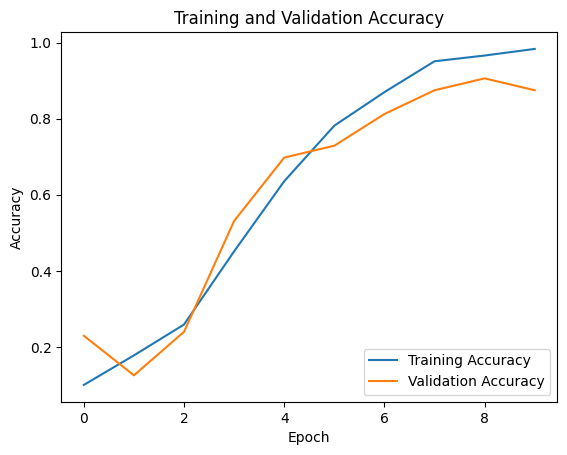

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 82ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9291666666666667
F1 Score: 0.9297913719766323
Precision: 0.9429405176938073
Recall: 0.9291666666666667


## Model 2

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(256, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 conv1d_1 (Conv1D)           (None, 5997, 512)         524800    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2998, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 2995, 256)         5245

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
108/108 [==============================] - 20s 150ms/step - loss: 2.7737 - accuracy: 0.0870 - val_loss: 2.6953 - val_accuracy: 0.0417
Epoch 2/10
108/108 [==============================] - 14s 132ms/step - loss: 2.4421 - accuracy: 0.1647 - val_loss: 2.2255 - val_accuracy: 0.1979
Epoch 3/10
108/108 [==============================] - 14s 132ms/step - loss: 1.9159 - accuracy: 0.3039 - val_loss: 1.7080 - val_accuracy: 0.3854
Epoch 4/10
108/108 [==============================] - 14s 131ms/step - loss: 1.5123 - accuracy: 0.4258 - val_loss: 1.6105 - val_accuracy: 0.5000
Epoch 5/10
108/108 [==============================] - 14s 126ms/step - loss: 1.1313 - accuracy: 0.5499 - val_loss: 1.6193 - val_accuracy: 0.3750
Epoch 6/10
108/108 [==============================] - 14s 130ms/step - loss: 0.9779 - accuracy: 0.6230 - val_loss: 1.0976 - val_accuracy: 0.6250
Epoch 7/10
108/108 [==============================] - 13s 122ms/step - loss: 0.6318 - accuracy: 0.7552 - val_loss: 1.2982 - val_ac

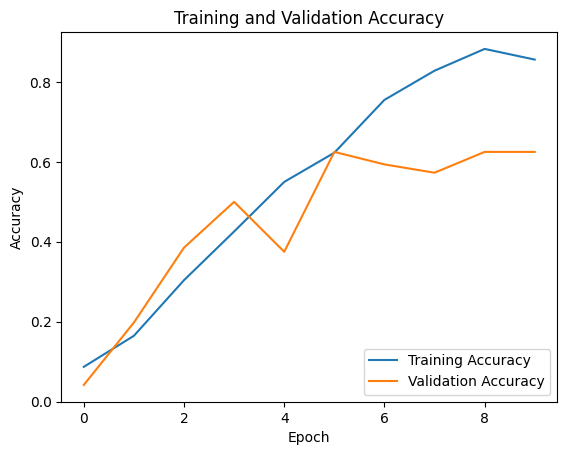

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 107ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.725
F1 Score: 0.7113739672591184
Precision: 0.7612254238816739
Recall: 0.725
